# Data Preprocessing (Part 1)

In [ ]:
# pip install pyspark

In [ ]:
# conda install -c cyclus java-jdk

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Spark in Anoconda")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

22/12/07 12:38:00 WARN Utils: Your hostname, clark-hainenghuang-PC resolves to a loopback address: 127.0.1.1; using 192.168.0.88 instead (on interface enp7s0)
22/12/07 12:38:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/07 12:38:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download all csv files containing API from 2015 to 2021, and merge them into one dataframe. All rows (days) that have no data recorded are stripped.

In [3]:
import numpy as np
import pandas as pd
import glob
import re
 
csv_list = glob.glob('*.csv')
print('There are %s个CSV文件'% len(csv_list))
print('正在处理............')
for i in csv_list:
    fr = open(i,'r',encoding='utf-8').read()
    with open('c.csv','a',encoding='utf-8') as f:
        f.write(fr)
print('合并完毕！')

共发现7个CSV文件
正在处理............
合并完毕！


In [4]:
df = spark.read.csv("c.csv", header=True, inferSchema=True)
#df = spark.read.csv("file:///C:/Users/John/OneDrive/fall 2022/24787 machine learning/Project/data-后/44201.csv", header=True, inferSchema=True)

In [5]:
df_c = df.groupBy("Latitude","Longitude","Event Type","POC").count().filter(df["Event Type"]=='None').orderBy(["Latitude","Longitude"])

In [6]:
df_c.show()

+---------+-----------+----------+---+-----+
| Latitude|  Longitude|Event Type|POC|count|
+---------+-----------+----------+---+-----+
|18.009558| -66.627249|      None|  1| 3608|
|18.198712| -66.052237|      None|  1| 2436|
|18.420089| -66.150615|      None|  1| 2529|
|18.422595| -66.120012|      None|  1| 3037|
|18.449814|  -66.05251|      None|  1| 2873|
| 21.30758| -157.85542|      None|  1| 4916|
|21.323745|-158.088613|      None|  2| 4947|
|21.323745|-158.088613|      None|  1| 5047|
|25.622049| -80.344255|      None|  1| 1776|
| 25.68333| -80.399722|      None|  1| 2492|
|25.785472| -80.284206|      None|  1|  170|
|25.798709| -80.210048|      None|  1| 4560|
|25.892518|  -97.49383|      None|  1| 2105|
|26.053889| -80.256944|      None|  1| 4641|
|26.128611| -80.167222|      None|  1| 1810|
|26.132677| -80.169817|      None|  1| 4389|
|27.501826| -99.502984|      None|  1| 1725|
|27.579045| -99.523949|      None|  1| 4185|
|27.834409| -82.665251|      None|  1| 4087|
|27.892801

# There are 358 different observation points in total

In [7]:
df_c.count()

358

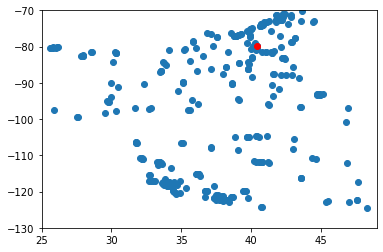

In [8]:
df_address = df_c.toPandas()

x = df_address['Latitude'].tolist()

y = df_address['Longitude'].tolist()

plt.scatter(x,y)
plt.xlim([25,49])
plt.ylim([-130,-70])
plt.plot(40.46542,-79.960757,"ro")# location for Pittsburgh

In [9]:
newdf = df.join(df_c,["Latitude","Longitude","POC","Event Type"]).orderBy(["Latitude","Longitude","POC"])

# Get rid of the locations at which the monitors have less than 2350 observations 


newdf["count"] > 2350

In [10]:
newdf_f = newdf.filter(newdf["count"] > 2350)
newdf_c = newdf_f.groupBy("Latitude","Longitude","POC","Event Type").count()
newdf_c.count()

276

num of points is 276


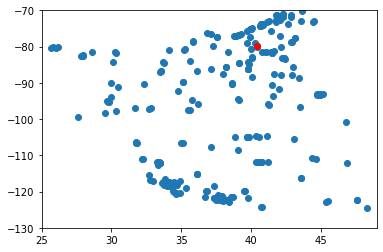

In [11]:
df_address = newdf_c.toPandas()

x = df_address['Latitude'].tolist()

y = df_address['Longitude'].tolist()

print("num of points is",newdf_c.count())

plt.scatter(x,y)
plt.xlim([25,49])
plt.ylim([-130,-70])
plt.plot(40.46542,-79.960757,"ro")
plt.show()

In [12]:
newdf_c.createOrReplaceTempView('newdf_c')
newdf_num = spark.sql('select row_number() over (order by "Latitude") as point_num, * from newdf_c')

22/12/07 12:38:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [13]:
df_filtered = newdf_f.join(newdf_num,["Latitude","Longitude","POC","Event Type","count"]).orderBy("point_num")

In [14]:
df_filtered.printSchema()

root
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- POC: integer (nullable = true)
 |-- Event Type: string (nullable = true)
 |-- count: long (nullable = false)
 |-- State Code: integer (nullable = true)
 |-- County Code: integer (nullable = true)
 |-- Site Num: integer (nullable = true)
 |-- Parameter Code: integer (nullable = true)
 |-- Datum: string (nullable = true)
 |-- Parameter Name: string (nullable = true)
 |-- Sample Duration: string (nullable = true)
 |-- Pollutant Standard: string (nullable = true)
 |-- Date Local: timestamp (nullable = true)
 |-- Units of Measure: string (nullable = true)
 |-- Observation Count: integer (nullable = true)
 |-- Observation Percent: double (nullable = true)
 |-- Arithmetic Mean: double (nullable = true)
 |-- 1st Max Value: double (nullable = true)
 |-- 1st Max Hour: integer (nullable = true)
 |-- AQI: integer (nullable = true)
 |-- Method Code: integer (nullable = true)
 |-- Method Name: string (nullable

In [15]:
df_filtered.coalesce (1).write.option("header",True).csv ('c')

22/12/07 12:38:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:38:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/07 12:38:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:38:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/07 12:38:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:38:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/07 12:39:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/07 12:39:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/07 12:39:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [16]:
num = newdf_num.count()
num

276

In [17]:
Coordinates = newdf_num.toPandas().iloc[:num+1,1:3]

22/12/07 12:39:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/07 12:39:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/07 12:39:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


22/12/07 12:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/12/07 12:39:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


# Generate coordinates and save them into a csv file

In [18]:
Coordinates

,Latitude,Longitude
0,43.466110,-88.621110
1,42.984173,-85.671339
2,42.385998,-83.266189
3,39.525083,-119.807717
4,36.139707,-115.175654
...,...,...
271,42.421502,-83.425042
272,39.064289,-108.561550
273,41.301400,-72.902871
274,29.670025,-95.128508


In [19]:
a = Coordinates.to_numpy()

In [20]:
a.shape

(276, 2)

In [21]:
Coordinates.to_csv('cord.csv',index=False)

In [22]:

df.groupBy("Site Num","Latitude","Longitude","City Name").count().where(df["City Name"]== 'Pittsburgh').show()

+--------+---------+----------+----------+-----+
|Site Num| Latitude| Longitude| City Name|count|
+--------+---------+----------+----------+-----+
|      31|40.443367|-79.990293|Pittsburgh| 4189|
|       8| 40.46542|-79.960757|Pittsburgh| 4770|
+--------+---------+----------+----------+-----+

